
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

# 🔴 **Import Libs**

In [ ]:
!python -m pip uninstall torch torchvision torchaudio -y
!python -m pip install --upgrade torch==2.2.0+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade torchdata
!pip install --upgrade torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics

In [79]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from datasets import load_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.2.0+cu118
0.17.0+cpu


In [4]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.0+cu118
torchtext --> 0.17.0+cpu
tqdm --> 4.66.5


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [23]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [8]:
tokenizer = get_tokenizer("basic_english")

# Build vocabulary from tokens
vocab = build_vocab_from_iterator(map(tokenizer, train_data['text']), 
                                  specials=['<sos>', '<eos>', '<unk>'], 
                                  min_freq=4)

vocab.set_default_index(vocab["<unk>"])
vocab_path = 'vocab.pt'
torch.save(vocab, vocab_path)

# Tokenize and index a sample text
sample_text = "Today is the best day in my  life."
tokenized_text = tokenizer(sample_text)
indexed_text = [vocab[token] for token in tokenized_text]

# Print tokenized and indexed text
print("\nTokenized Text:", tokenized_text)
print("Indexed Text:", indexed_text)

# Len Vocab
print("Lnegth Vocab:", len(vocab))


Tokenized Text: ['today', 'is', 'the', 'best', 'day', 'in', 'my', 'life', '.']
Indexed Text: [805, 25, 3, 177, 134, 8, 450, 167, 5]
Lnegth Vocab: 24292


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [9]:
# Initialize variables
num_documents = len(train_data)
total_words = 0
total_lengths = []

# Calculate statistics
for doc in train_data:
    tokens = tokenizer(doc["text"])
    total_words += len(tokens)
    total_lengths.append(len(tokens))

avg_doc_length = total_words / num_documents if num_documents > 0 else 0

# Display statistics
print("Training Set Statistics:")
print(f"num_documents: {num_documents}")
print(f"total_words: {total_words}")
print(f"avg_doc_length: {avg_doc_length}")
print(f"min_doc_length: {min(total_lengths)}")
print(f"max_doc_length: {max(total_lengths)}")


Training Set Statistics:
num_documents: 36718
total_words: 2051665
avg_doc_length: 55.87627321749551
min_doc_length: 0
max_doc_length: 696


### 🟡 Analyze the most common and least common words in the dataset.

In [10]:
# Compute word frequencies in the training dataset
freqs = Counter()
for tokens in map(tokenizer, train_data['text']):
    freqs.update(tokens)

# Find the 10 least common words
least_common_words = freqs.most_common()[:-11:-1]
print("Least Common Words:")
for word, count in least_common_words:
    print(f"{word}: {count}")

# Find the 10 most common words
most_common_words = freqs.most_common(10)
print("\nMost Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Least Common Words:
pâté: 1
casseroled: 1
kv: 1
nay: 1
holler: 1
manawydan: 1
bran: 1
tamed: 1
branwen: 1
messy: 1

Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

## N-grams Analysis:

We'll perform bigram analysis (for two consecutive words) in the dataset and print the most common bigrams.

In [11]:
# Initialize 3-gram counter
grams = Counter()

# Count 3-grams in the dataset
for doc in train_data:
    tokens = tokenizer(doc["text"])
    
    # Skip documents with fewer than 3 tokens to avoid StopIteration error
    if len(tokens) >= 3:
        grams.update(ngrams(tokens, 3)) 

# Get most common 3-grams
most_common_grams = grams.most_common(15)

# Print most common 3-grams
print("Most Common Bigrams:")
for gram, count in most_common_grams:
    print(f"{gram}: {count}")

Most Common Bigrams:
('=', '=', '='): 5956
('@', '.', '@'): 3194
('@', ',', '@'): 2699
(',', '@', '000'): 1446
(',', 'and', 'the'): 1407
('one', 'of', 'the'): 869
('.', 'however', ','): 806
('.', '.', '.'): 782
('.', 'in', 'the'): 753
('.', 'it', 'was'): 714
('the', 'united', 'states'): 667
('as', 'well', 'as'): 603
('part', 'of', 'the'): 533
('the', 'end', 'of'): 509
('.', 's', '.'): 491


## Word Length Distribution:
- Compute the distribution of word lengths (i.e., the number of characters per word) in the dataset.

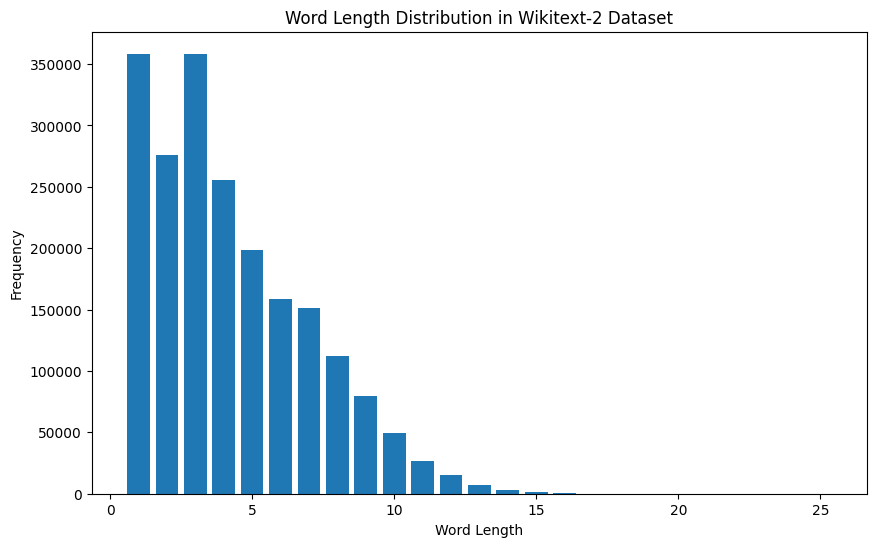

In [12]:
# Compute the word lengths in the training dataset
word_lengths = []
for tokens in map(tokenizer, train_data['text']):
    word_lengths.extend(len(word) for word in tokens)

# Create a frequency distribution of word lengths
word_length_counts = Counter(word_lengths)

# Plot the word length distribution
plt.figure(figsize=(10, 6))
plt.bar(word_length_counts.keys(), word_length_counts.values())
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.title("Word Length Distribution in Wikitext-2 Dataset")
plt.show()

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [52]:
def data_process(dataset, sequence_length):

    # Convert the raw text iterator into a single PyTorch tensor
    data = torch.cat([torch.LongTensor([vocab['<sos>']] + vocab(tokenizer(line)) + [vocab['<eos>']]) for line in dataset['text']])

    # Calculate the number of complete sequences that can be formed
    num_sequences = len(data) // sequence_length

    # Calculate the remainder of the data length divided by the sequence length
    remainder = len(data) % sequence_length

    # If the remainder is 0, add a single <unk> token to the end of the data tensor
    if remainder == 0:
        unk_tokens = torch.LongTensor([vocab['<unk>']])
        data = torch.cat([data, unk_tokens])

    # Extract the input and target sequences from the data tensor
    inputs  = data[:num_sequences*sequence_length].reshape(-1, sequence_length)
    targets = data[1:num_sequences*sequence_length+1].reshape(-1, sequence_length)

    return inputs, targets

In [53]:
sequence_length = 30
X_train, y_train = data_process(train_data, sequence_length)
X_valid, y_valid = data_process(val_data, sequence_length)
X_test, y_test   = data_process(test_data, sequence_length)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([70836, 30]),
 torch.Size([70836, 30]),
 torch.Size([7406, 30]),
 torch.Size([7406, 30]),
 torch.Size([8362, 30]),
 torch.Size([8362, 30]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [54]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]


In [58]:
train_dataset = LanguageModelDataset(X_train, y_train)
valid_dataset = LanguageModelDataset(X_valid, y_valid)
test_dataset  = LanguageModelDataset(X_test, y_test)

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [60]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [61]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        dropout=dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction


In [65]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)
model

LanguageModel(
  (embedding): Embedding(24292, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=24292, bias=True)
)

In [66]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(7.2876, 3.76832, 12.461796)

# 🔴 **Config**

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [70]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss()
metric = tm.text.Perplexity().to(device)

print("Model Summary:")
print(model)
print(f"Optimizer: {optimizer}")
print(f"Loss Function: {loss_fn}")
print(f"Metric: {metric}")

Model Summary:
LanguageModel(
  (embedding): Embedding(24292, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=24292, bias=True)
)
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.5
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
Loss Function: CrossEntropyLoss()
Metric: Perplexity()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [71]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric.reset()
    clip = 0.25
    
    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch:
                tepoch.set_description(f'Epoch {epoch}')
        
            inputs = inputs.to(device)
            targets = targets.to(device)
        
            outputs = model(inputs)
        
            loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
        
            loss.backward()
        
            nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)
        
            optimizer.step()
            optimizer.zero_grad()
        
            loss_train.update(loss.item(), n=len(targets))
            metric.update(outputs, targets)
        
            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())
    
    return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [72]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [81]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5).to(device)

inputs, targets = next(iter(train_set))
inputs, targets = inputs.to(device), targets.to(device)
 

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(10.0972, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [82]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=2., momentum=0.9)

In [83]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [84]:
num_epochs = 100
for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 28.29batch/s, loss=0.371, metric=1.45]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [89]:
num_epochs = 5

for lr in [1, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), 
                        embedding_dim=300,
                        hidden_dim=512, 
                        num_layers=2,
                        dropout_embd=0.5, 
                        dropout_rnn=0.2).to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=1


Epoch 4: 100%|██████████| 2214/2214 [01:51<00:00, 19.82batch/s, loss=4.68, metric=108]



LR=0.1


Epoch 4: 100%|██████████| 2214/2214 [01:49<00:00, 20.29batch/s, loss=5.9, metric=364] 



LR=0.01


Epoch 4: 100%|██████████| 2214/2214 [01:49<00:00, 20.21batch/s, loss=6.85, metric=940]



LR=0.001


Epoch 4: 100%|██████████| 2214/2214 [01:50<00:00, 20.12batch/s, loss=7.2, metric=1.34e+3] 

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [92]:
num_epochs = 2

for lr in [1]:
  for wd in [1e-6, 1e-5, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), 
                          embedding_dim=300,
                          hidden_dim=512, 
                          num_layers=2,
                          dropout_embd=0.5, 
                          dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=1, WD=1e-06


Epoch 1: 100%|██████████| 2214/2214 [01:51<00:00, 19.88batch/s, loss=5.32, metric=205]



LR=1, WD=1e-05


Epoch 1: 100%|██████████| 2214/2214 [01:51<00:00, 19.92batch/s, loss=5.35, metric=211]



LR=1, WD=0.0001


Epoch 1: 100%|██████████| 2214/2214 [01:50<00:00, 20.03batch/s, loss=5.7, metric=298] 

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [109]:
model = LanguageModel(len(vocab), 
                      embedding_dim=300,
                      hidden_dim=512, 
                      num_layers=2,
                      dropout_embd=0.5, 
                      dropout_rnn=0.2).to(device)

In [110]:
wd = 1e-5
lr = 1
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [111]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [112]:
num_epochs = 5

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2214/2214 [01:52<00:00, 19.60batch/s, loss=5.98, metric=393]   


Model Saved!
Valid: Loss = 5.407, Metric = 222.9



Epoch 1: 100%|██████████| 2214/2214 [01:52<00:00, 19.76batch/s, loss=5.37, metric=214]


Model Saved!
Valid: Loss = 5.175, Metric = 176.8



Epoch 2: 100%|██████████| 2214/2214 [01:52<00:00, 19.63batch/s, loss=5.11, metric=166]


Model Saved!
Valid: Loss = 5.056, Metric = 157.0



Epoch 3: 100%|██████████| 2214/2214 [01:52<00:00, 19.76batch/s, loss=4.95, metric=141]


Model Saved!
Valid: Loss = 4.972, Metric = 144.3



Epoch 4: 100%|██████████| 2214/2214 [01:52<00:00, 19.77batch/s, loss=4.83, metric=125]


Model Saved!
Valid: Loss = 4.925, Metric = 137.7



## 🟠 Main Loop

🔰 Define model.

In [113]:
model = torch.load('model.pt').to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [115]:
lr = 1
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [116]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [117]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2214/2214 [01:55<00:00, 19.25batch/s, loss=4.74, metric=114]


Model Saved!
Valid: Loss = 4.903, Metric = 134.7



Epoch 1: 100%|██████████| 2214/2214 [01:52<00:00, 19.71batch/s, loss=4.67, metric=106]


Model Saved!
Valid: Loss = 4.874, Metric = 130.9



Epoch 2: 100%|██████████| 2214/2214 [01:53<00:00, 19.48batch/s, loss=4.61, metric=101] 


Model Saved!
Valid: Loss = 4.854, Metric = 128.3



Epoch 3: 100%|██████████| 2214/2214 [01:53<00:00, 19.49batch/s, loss=4.57, metric=96.2]


Model Saved!
Valid: Loss = 4.836, Metric = 125.9



Epoch 4: 100%|██████████| 2214/2214 [01:52<00:00, 19.62batch/s, loss=4.53, metric=92.6]


Valid: Loss = 4.836, Metric = 126.0



Epoch 5: 100%|██████████| 2214/2214 [01:53<00:00, 19.58batch/s, loss=4.5, metric=89.8] 


Model Saved!
Valid: Loss = 4.83, Metric = 125.2



Epoch 6: 100%|██████████| 2214/2214 [01:52<00:00, 19.75batch/s, loss=4.47, metric=87.5]


Model Saved!
Valid: Loss = 4.825, Metric = 124.6



Epoch 7: 100%|██████████| 2214/2214 [01:52<00:00, 19.63batch/s, loss=4.45, metric=85.6]


Valid: Loss = 4.828, Metric = 124.9



Epoch 8: 100%|██████████| 2214/2214 [01:53<00:00, 19.54batch/s, loss=4.43, metric=84]  


Model Saved!
Valid: Loss = 4.817, Metric = 123.6



Epoch 9: 100%|██████████| 2214/2214 [01:52<00:00, 19.63batch/s, loss=4.42, metric=82.7]


Valid: Loss = 4.819, Metric = 123.8



Epoch 10: 100%|██████████| 2214/2214 [01:52<00:00, 19.62batch/s, loss=4.4, metric=81.5] 


Model Saved!
Valid: Loss = 4.816, Metric = 123.5



Epoch 11: 100%|██████████| 2214/2214 [01:53<00:00, 19.57batch/s, loss=4.39, metric=80.5]


Model Saved!
Valid: Loss = 4.811, Metric = 122.8



Epoch 12: 100%|██████████| 2214/2214 [01:53<00:00, 19.55batch/s, loss=4.38, metric=79.6]


Model Saved!
Valid: Loss = 4.801, Metric = 121.6



Epoch 13: 100%|██████████| 2214/2214 [01:53<00:00, 19.56batch/s, loss=4.37, metric=78.8]


Model Saved!
Valid: Loss = 4.799, Metric = 121.4



Epoch 14: 100%|██████████| 2214/2214 [01:53<00:00, 19.59batch/s, loss=4.36, metric=78.2]


Valid: Loss = 4.805, Metric = 122.1



## 🟠 Plot

🔰 Plot learning curves

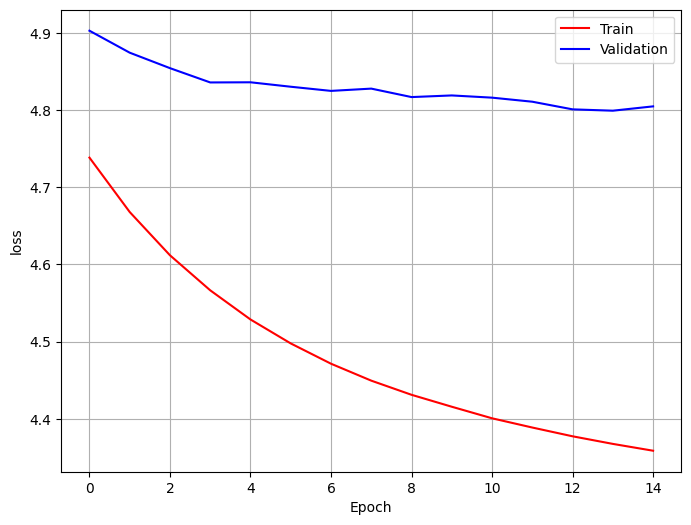

In [118]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [120]:
model = torch.load('model.pt').to(device)
test_loss, test_metric = evaluate(model, test_loader, loss_fn, metric)
print(f'Test: Loss = {test_loss:.4}, Metric = {test_metric:.4}')

Test: Loss = 4.729, Metric = 113.2


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [126]:
model = torch.load('model.pt').to(device)
model.eval()

LanguageModel(
  (embedding): Embedding(24292, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=24292, bias=True)
)

In [236]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()
  flag = 0  
  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)
    with torch.no_grad():
      prediction = model(src)

    # Low values like 0.1 for temperature, Makes softmax like argmax more
    probs = torch.softmax(prediction[-1]/temperature, dim = 0)
    idx = vocab["<unk>"]
    while idx == vocab["<unk>"]:
      idx = torch.multinomial(probs, num_samples =1).item()
    indices.append(idx)
    if idx == vocab[","] or idx == vocab["."]:
        prompt += itos[idx]
    elif idx == vocab["'"]:
        prompt += itos[idx]
        flag = 1
    else:
        if flag == 1:
            prompt += itos[idx]
            flag = 0
        else:
            prompt += " " + itos[idx]
            

    if idx == vocab["."]:
      return prompt

In [323]:
prompt = "He is an athlete who"
generate(prompt, 50, 0.5, model, tokenizer, vocab, seed=None)

'He is an athlete who is killed by a number of police members.'